## 11	ASIGNACIÓN DE ACTIVOS PARA UN PORTAFOLIO EFICIENTE EN PYTHON

## 11.1	Evaluar el rendimiento de un 1 / n portafolio básico

In [1]:
# 1. Importar librerías

import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf


C:\Users\crami\anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


[*********************100%***********************]  4 of 4 completed


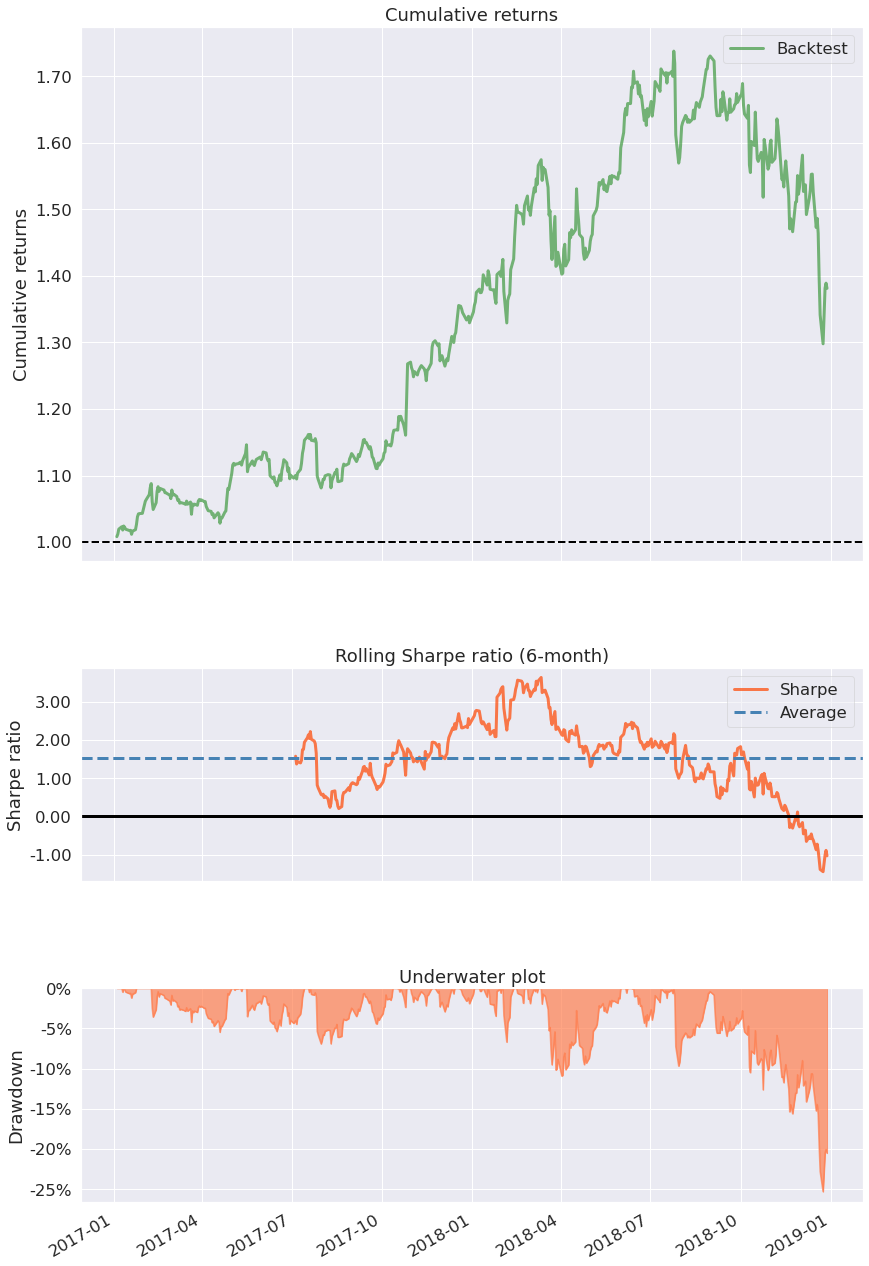

In [2]:
# 2. Configurar los parámetros
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT', 'TWTR']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)
# 3. Descargue los precios de las acciones de Yahoo Finance:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
 end=END_DATE, adjusted=True)
# 4. Calcular los rendimientos de los activos individuales:
returns = prices_df['Adj Close'].pct_change().dropna()
# 5. Definir los pesos o participaciones
portfolio_weights = n_assets * [1 / n_assets]
# 6. Calcule los rendimientos del portafolio:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
 index=returns.index)
# 7. Crear la hoja de lágrimas 
pf.create_simple_tear_sheet(portfolio_returns)


## 11.2	Encontrar la frontera eficiente usando Simulación Montecarlo

In [4]:
# 1. Importar librerías

import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# 2. Configurar los parámetros

N_PORTFOLIOS = 10 ** 5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'TSLA', 'TWTR', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)

#3. Descargue los precios de las acciones de Yahoo Finance:

prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
 end=END_DATE, adjusted=True)

# 4. Calcule los rendimientos promedio anualizados y la desviación estándar correspondiente:

returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

# 5. Simule ponderaciones de portafolio aleatorias:

np.random.seed(42)
weights = np.random.random(size=(N_PORTFOLIOS, n_assets))
weights /= np.sum(weights, axis=1)[:, np.newaxis]

# 6. Calcule las métricas del portafolio:

portf_rtns = np.dot(weights, avg_returns)
portf_vol = []
for i in range(0, len(weights)):
 portf_vol.append(np.sqrt(np.dot(weights[i].T,
 np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns / portf_vol

# 7. Cree un DataFrame que contenga todos los datos:

portf_results_df = pd.DataFrame({'returns': portf_rtns,
 'volatility': portf_vol,
 'sharpe_ratio':
 portf_sharpe_ratio})

# 8. Localice los puntos que crean la frontera eficiente:

N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []
portf_rtns_ef = np.linspace(portf_results_df.returns.min(),
 portf_results_df.returns.max(),
 N_POINTS)
portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)
for point_index in range(N_POINTS):
 if portf_rtns_ef[point_index] not in portf_rtns:
     indices_to_skip.append(point_index)
     continue
 matched_ind = np.where(portf_rtns ==
                         portf_rtns_ef[point_index])
 portf_vol_ef.append(np.min(portf_vol[matched_ind]))
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

# 9. Graficar la frontera eficiente

MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
 y='returns', c='sharpe_ratio',
 cmap='RdYlGn', edgecolors='black',
 ax=ax)
ax.set(xlabel='Volatility',
 ylabel='Expected Returns',
 title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
 ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),
 y=avg_returns[asset_index],
 marker=MARKS[asset_index],
 s=150,
 color='black',
 label=RISKY_ASSETS[asset_index])
ax.legend()



[*********************100%***********************]  4 of 4 completed


In [5]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

#También podemos investigar los componentes de estas portafolios:

print('Maximum Sharpe ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
 print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS,
weights[np.argmax(portf_results_df.sharpe_ratio)]):
 print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe ratio portfolio ----
Performance
returns: 23.42% volatility: 29.77% sharpe_ratio: 78.68% 
Weights
FB: 0.01% MSFT: 75.18% TSLA: 5.80% TWTR: 19.00% 

In [6]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Minimum Volatility portfolio ----
Performance
returns: 13.45% volatility: 27.56% sharpe_ratio: 48.79% 
Weights
FB: 17.80% MSFT: 78.75% TSLA: 2.94% TWTR: 0.50% 

In [7]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
 y='returns', c='sharpe_ratio',
 cmap='RdYlGn', edgecolors='black',
 ax=ax)
ax.scatter(x=max_sharpe_portf.volatility,
 y=max_sharpe_portf.returns,
 c='black', marker='*',
 s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility,
 y=min_vol_portf.returns,
 c='black', marker='P',
 s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns',
 title='Efficient Frontier')
ax.legend()


## 11.3	Encontrar la frontera eficiente usando optimización con scipy

In [8]:
# 1.Importar librerías

import numpy as np
import scipy.optimize as sco

# 2. Definir funciones para calcular los rendimientos de la portafolio y la volatilidad:

def get_portf_rtn(w, avg_rtns):
 return np.sum(avg_rtns * w)
def get_portf_vol(w, avg_rtns, cov_mat):
 return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

# 3. Defina la función que calcula la frontera eficiente:

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
     efficient_portfolios = []
     n_assets = len(avg_returns)
     args = (avg_returns, cov_mat)
     bounds = tuple((0,1) for asset in range(n_assets))
     initial_guess = n_assets * [1. / n_assets, ]
     for ret in rtns_range:
         constraints = ({'type': 'eq',
                     'fun': lambda x: get_portf_rtn(x, avg_rtns)
                     - ret},
                     {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1})
         efficient_portfolio = sco.minimize(get_portf_vol,
                                             initial_guess,
                                             args=args,
                                            method='SLSQP',
                                             constraints=constraints,
                                             bounds=bounds)
         efficient_portfolios.append(efficient_portfolio)
     return efficient_portfolios

# 4. Defina el rango considerado de rendimientos:

rtns_range = np.linspace(-0.22, 0.32, 200)

# 5.Calcule la frontera eficiente:

efficient_portfolios = get_efficient_frontier(avg_returns,
                                             cov_mat,
                                             rtns_range)

# 6.Extraiga las volatilidades de las portafolios eficientes:

vols_range = [x['fun'] for x in efficient_portfolios]

# 7.Trace la frontera eficiente calculada, junto con las portafolios simuladas:

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',
 y='returns', c='sharpe_ratio',
 cmap='RdYlGn', edgecolors='black',
 ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility',
 ylabel='Expected Returns',
 title='Efficient Frontier')



[Text(0.5, 0, 'Volatility'),
 Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 1.0, 'Efficient Frontier')]

In [9]:
# 8. Identifique el portafolio de volatilidad mínima:

min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']
min_vol_portf = {'Return': min_vol_portf_rtn,
 'Volatility': min_vol_portf_vol,
 'Sharpe Ratio': (min_vol_portf_rtn /
 min_vol_portf_vol)}

# 9.Imprima el resumen de rendimiento:

print('Minimum volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
 print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS,
efficient_portfolios[min_vol_ind]['x']):
 print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Minimum volatility portfolio ----
Performance
Return: 13.01% Volatility: 27.54% Sharpe Ratio: 47.22% 
Weights
FB: 18.65% MSFT: 77.34% TSLA: 4.01% TWTR: 0.00% 

In [10]:
# 1. Defina la función objetivo (relación de Sharpe negativa):

def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
     portf_returns = np.sum(avg_rtns * w)
     portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
     portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
     return -portf_sharpe_ratio

# 2. Encontrar el portafolio óptimo

n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                 x0=initial_guess,
                                 args=args,
                                 method='SLSQP',
                                 bounds=bounds,
                                 constraints=constraints)

# 3. Extraiga información sobre el portafolio con la máxima relación de Sharpe:

max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w,
                                             avg_returns),
                     'Volatility': get_portf_vol(max_sharpe_portf_w,
                                                 avg_returns,
                                                 cov_mat),
                     'Sharpe Ratio': -max_sharpe_portf['fun']}

# 4. Imprima el resumen de rendimiento:

print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
  print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
  print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
  print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe Ratio portfolio ----
Performance
Return: 23.10% 
Weights
Volatility: 29.25% 
Weights
Sharpe Ratio: 78.97% 
Weights
FB: 0.00% MSFT: 81.50% TSLA: 2.79% TWTR: 15.72% 